In [1]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from torchvision.transforms import v2

## Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/AugmentedDataCS433'

In [ ]:
whole_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize(
            mean = [0.082],
            std= [0.256])
        ])
)

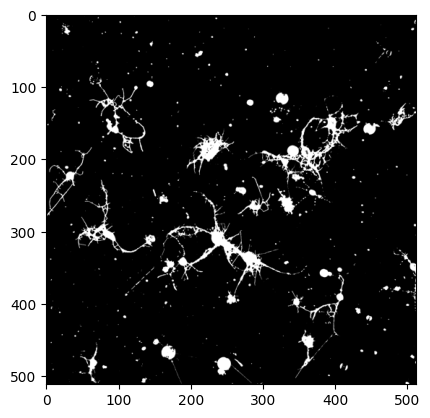

In [ ]:
def display_image(image):
  image_np = image.numpy()
  img_plt = image_np.reshape(512,512)
  plt.imshow(img_plt,cmap='gray')

display_image(whole_dataset[0][0])

In [ ]:
np.unique(np.array(whole_dataset.targets),return_counts=True)

(array([0, 1]), array([ 384, 1152]))

In [ ]:
whole_dataset.classes

['DISEASED', 'WT']

In [ ]:
targets = [sample[1] for sample in whole_dataset]

# Split indices using stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, val_index = next(sss.split(range(len(whole_dataset)), targets))

# Create Subset datasets
train_dataset = Subset(whole_dataset, train_index)
val_dataset = Subset(whole_dataset, val_index)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

## Model training

In [ ]:
def train_epoch(model, optimizer, scheduler, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target, weight=torch.tensor([0.76, 0.24], dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        loss_float = loss.item()
        accuracy_float = correct / len(data)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += torch.nn.functional.cross_entropy(output, target, weight=torch.tensor([0.76, 0.24], dtype=torch.float32)).item() * len(data)
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)

        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    train_loader,
    val_loader,
    device="cuda"
):

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    # ===== Plot low/high loss predictions on validation set =====
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )
    points.sort(key=lambda x: x[1])
    plt.figure(figsize=(15, 6))
    for k in range(5):
        plt.subplot(2, 5, k + 1)
        plt.imshow(points[k][0][0, 0], cmap="gray")
        plt.title(f"true={ whole_dataset.classes[int(points[k][3])] } pred={ whole_dataset.classes[int(points[k][2])]}")
        plt.subplot(2, 5, 5 + k + 1)
        plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
        plt.title(f"true={whole_dataset.classes[int(points[-k-1][3])]} pred={whole_dataset.classes[int(points[-k-1][2])]}")

    return sum(train_acc) / len(train_acc), val_acc

## Hyperparameters tuning

**We tried multiple architectures some simpler than this one, some more complicated. We also tried different batch sizes, different weights in the cross_entropy loss and different initial learning rates ranging from 1e-3 to 1e-4. Model always tended to converge to constant prediction (sometimes always 'DISEASED' as in the example below, when the weight associated with that class was high enough (>0.75))**

In [ ]:
model1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels= 12, kernel_size=5, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(12,32,5,2,2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32,64,5,2,2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64,128,5,2,2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Conv2d(128,2,1),
    torch.nn.Flatten()
)


Train Epoch: 1-000 batch_loss=6.93e-01 batch_acc=0.250 lr=4.999e-04 
Train Epoch: 1-001 batch_loss=6.92e-01 batch_acc=0.562 lr=4.995e-04 
Train Epoch: 1-002 batch_loss=6.65e-01 batch_acc=0.875 lr=4.988e-04 
Train Epoch: 1-003 batch_loss=7.37e-01 batch_acc=0.750 lr=4.978e-04 
Train Epoch: 1-004 batch_loss=6.76e-01 batch_acc=0.812 lr=4.966e-04 
Train Epoch: 1-005 batch_loss=7.05e-01 batch_acc=0.719 lr=4.951e-04 
Train Epoch: 1-006 batch_loss=6.89e-01 batch_acc=0.766 lr=4.933e-04 
Train Epoch: 1-007 batch_loss=6.85e-01 batch_acc=0.797 lr=4.913e-04 
Train Epoch: 1-008 batch_loss=7.10e-01 batch_acc=0.688 lr=4.890e-04 
Train Epoch: 1-009 batch_loss=6.91e-01 batch_acc=0.734 lr=4.865e-04 
Train Epoch: 1-010 batch_loss=6.98e-01 batch_acc=0.625 lr=4.836e-04 
Train Epoch: 1-011 batch_loss=6.90e-01 batch_acc=0.656 lr=4.806e-04 
Train Epoch: 1-012 batch_loss=6.92e-01 batch_acc=0.594 lr=4.773e-04 
Train Epoch: 1-013 batch_loss=6.91e-01 batch_acc=0.484 lr=4.737e-04 
Train Epoch: 1-014 batch_loss=6.91

(0.25, 0.25)

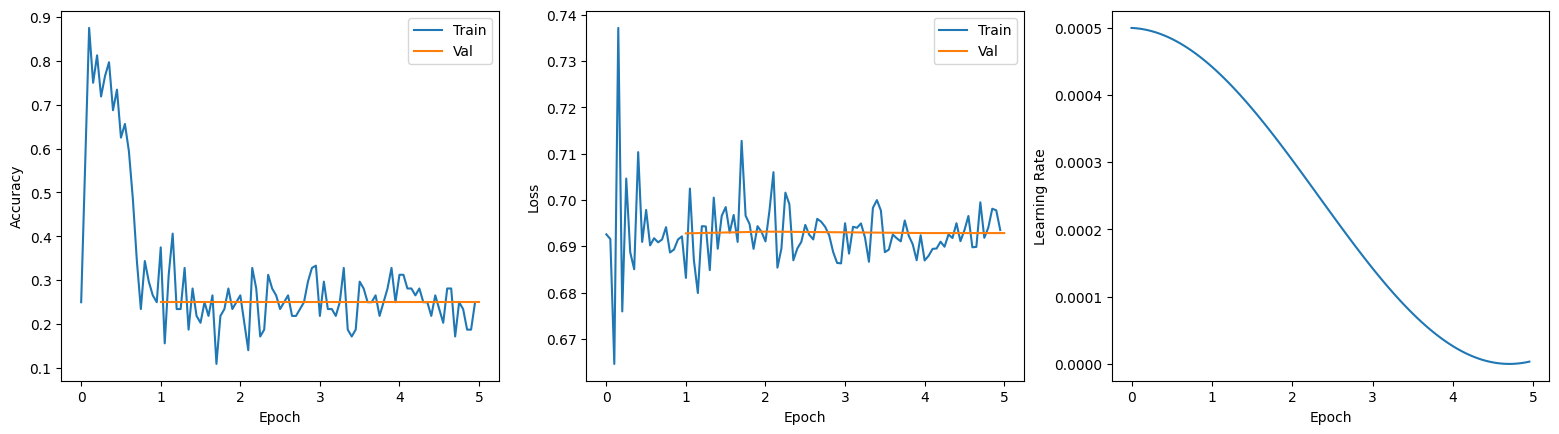

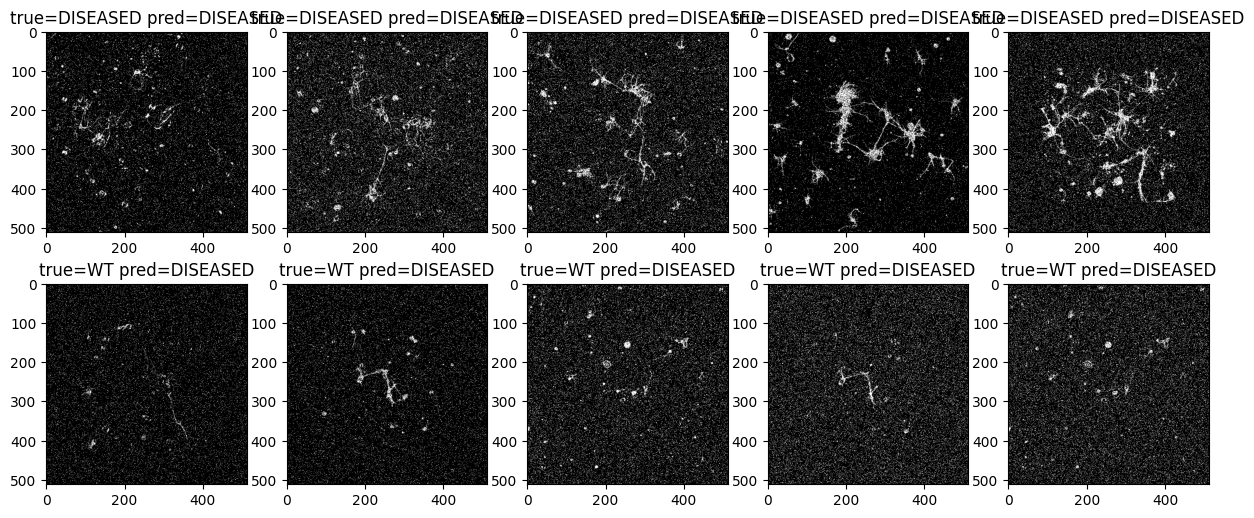

In [ ]:
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-2,
)

run_training(
    model=model1,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

## Getting insights on what the model captures

**This section should have been used in case of good results to get insights on what the model relied on to classify images. We could have imagined that it captured specfic features of the ALzheimer's neurons**

### Looking at the filters

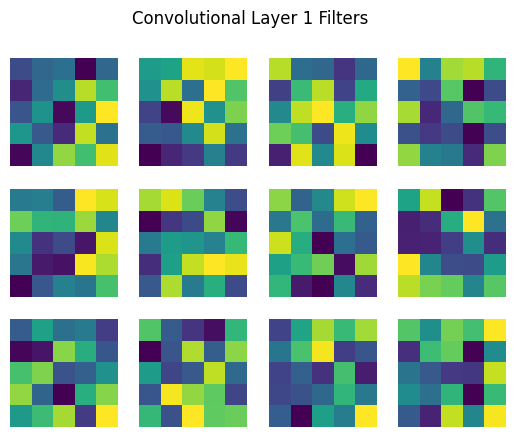

In [ ]:
#Focusing on the convolutional layers
conv_layers = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]
#Focusing on the first one
first_conv = conv_layers[0]

filters = first_conv.weight.data


# Plot each filter
for j in range(filters.size(0)):
    plt.subplot(3, filters.size(0)//3, j + 1)
    plt.imshow(filters[j].cpu().numpy().reshape(filters[0].shape[1],filters[0].shape[2]), cmap='viridis')
    plt.axis('off')


plt.suptitle(f"Convolutional Layer 1 Filters")
plt.show()

### Looking at the features maps

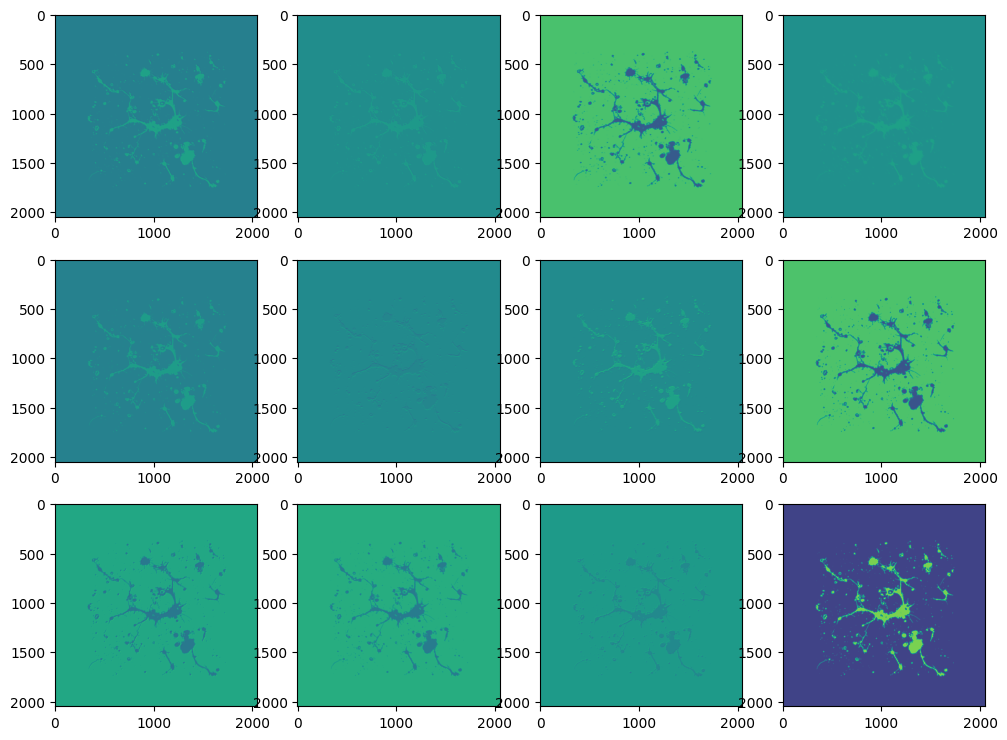

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[0].register_forward_hook(get_activation('Convolution_1'))
x = val_dataset[1][0]
output = model(x)

fig, axs = plt.subplots(3,4,figsize=(12, 9))
for i in range(12):
  feat_map = activation['Convolution_1'][i]
  axs[i//4][i%4].imshow(feat_map)


In [ ]:
axs

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)